<a href="https://colab.research.google.com/github/revanth1718/DSPROJECTS/blob/main/Facial_Expression_Recognition_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset available at kaggle 

https://www.kaggle.com/jonathanoheix/face-expression-recognition-dataset

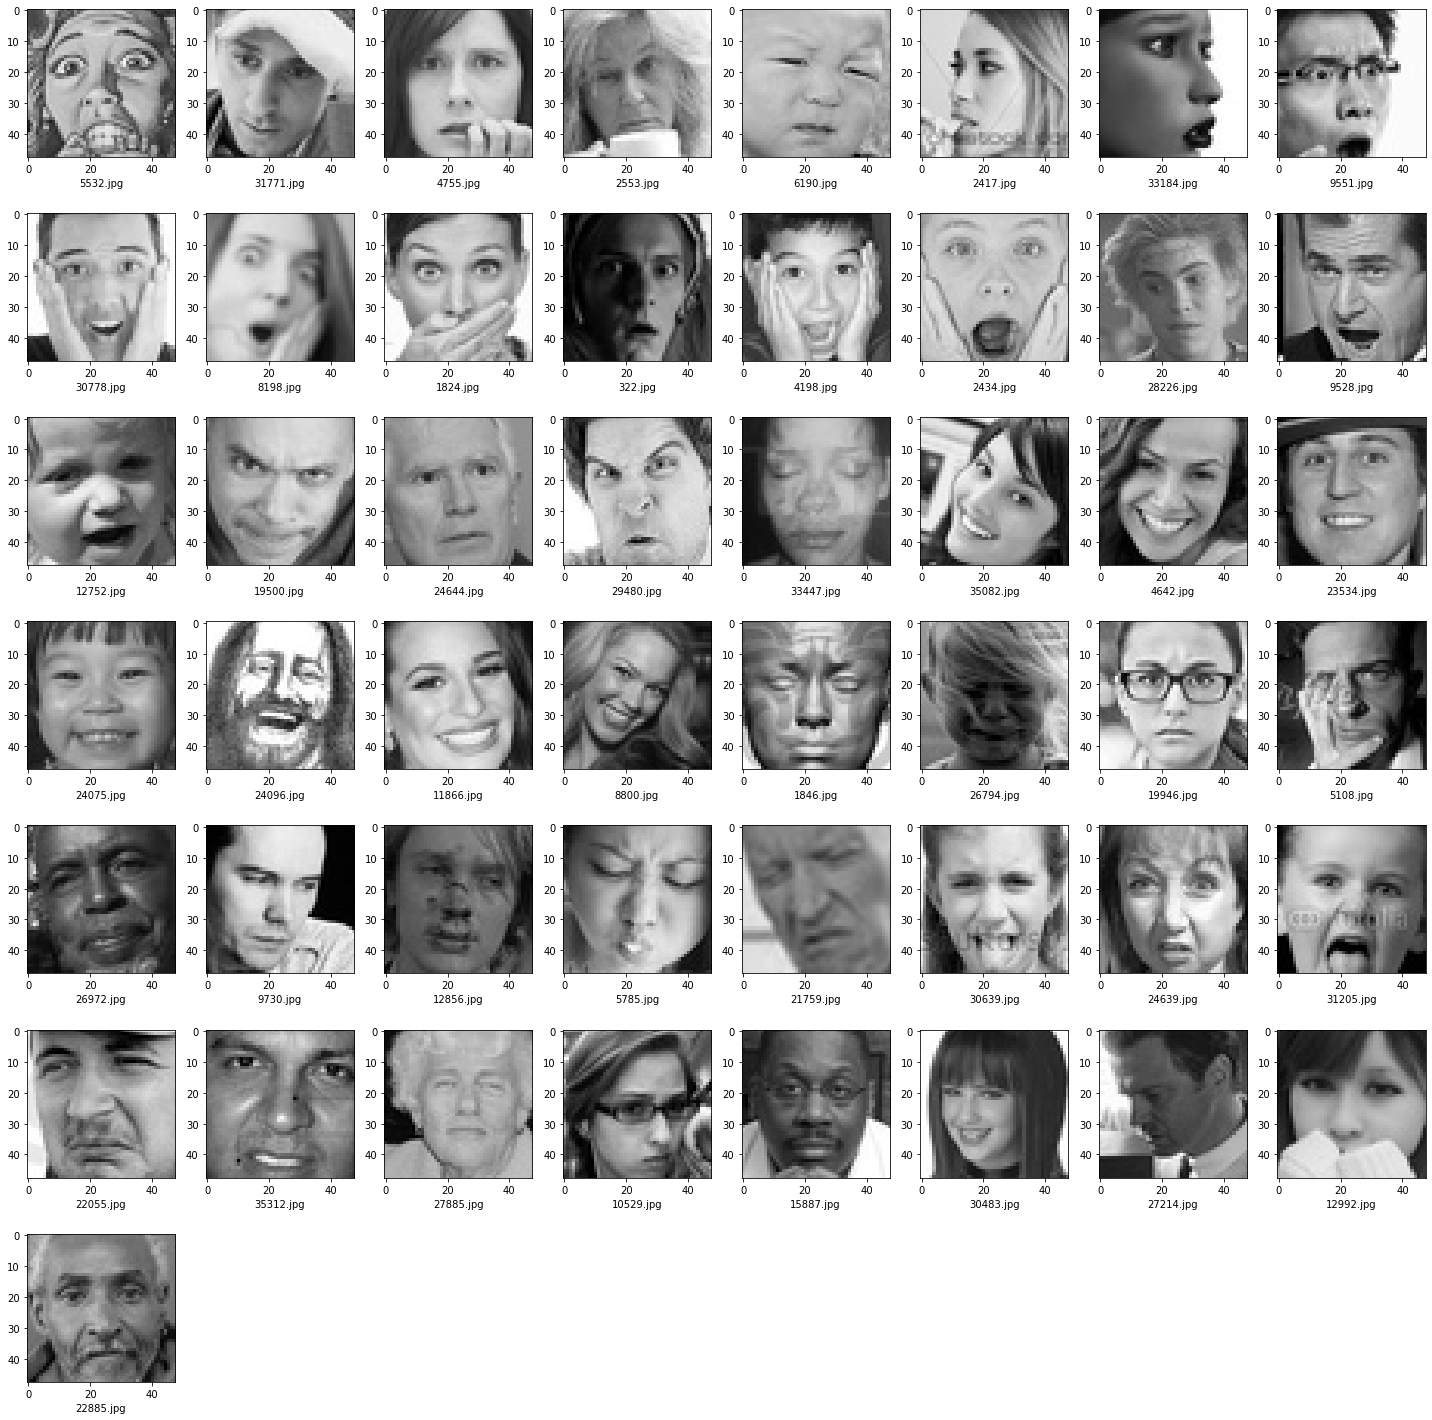

# Install libraries, packages and dataset

In [ ]:
!git clone https://github.com/parth1620/Facial-Expression-Dataset.git
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

Cloning into 'Facial-Expression-Dataset'...
remote: Enumerating objects: 34052, done.
remote: Total 34052 (delta 0), reused 0 (delta 0), pack-reused 34052
Receiving objects: 100% (34052/34052), 52.31 MiB | 46.18 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Updating files: 100% (35887/35887), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-6in_nuxa
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-6in_nuxa
  Resolved https://github.com/albumentations-team/albumentations to commit b773a1aa69f9c823c7f593205614d05d32c039cb
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-1.3.0-py3-none-any.whl size=125696 sha256=1da32cd3770b9f4924504fb75c15b50911011f0dd3d83e25e674ab34382cb8c1
  Stored in directory: /tmp/pip-ephem-whee

# Imports

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import torch 

# Configurations

In [ ]:
TRAIN_IMG_FOLDER_PATH = '/content/Facial-Expression-Dataset/train/'
VALID_IMG_FOLDER_PATH = '/content/Facial-Expression-Dataset/validation/'

LR = 0.001
BATCH_SIZE = 32
EPOCHS = 15

DEVICE = "cuda"
MODEL_NAME = 'efficient_b0'

# Load Dataset 

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision import transforms as T 

In [ ]:
train_augs = T.Compose([
    T.RandomHorizontalFlip(p = 0.5),
    T.RandomRotation(degrees=(-20, +20)),
    T.ToTensor() # PIL / numpy arr -> torch tensor -> (h, w, c) -> (c, h, w)
])

valid_augs = T.Compose([
    T.ToTensor()
])

In [ ]:
trainset = ImageFolder(TRAIN_IMG_FOLDER_PATH, transform = train_augs)
validset = ImageFolder(VALID_IMG_FOLDER_PATH, transform = valid_augs)

In [ ]:
print(f"Total no. of examples in trainset : {len(trainset)}")
print(f"Total no. of examples in validset : {len(validset)}")

Total no. of examples in trainset : 28821
Total no. of examples in validset : 7066


In [ ]:
print(trainset.class_to_idx)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


Text(0.5, 1.0, '0')

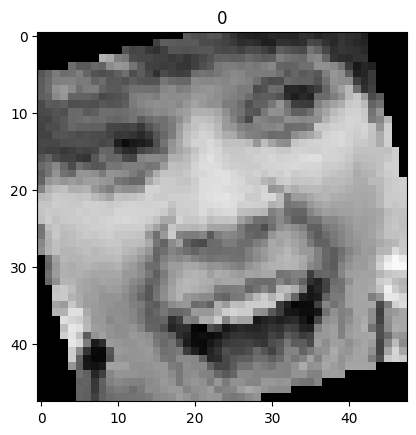

In [ ]:
image, label = trainset[500]

plt.imshow(image.permute(1, 2, 0)) # (h, w, c)
plt.title(label)

Text(0.5, 1.0, '4')

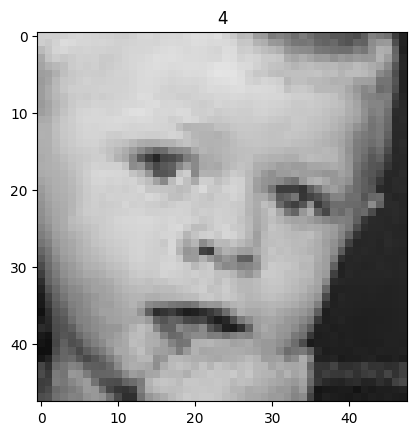

In [ ]:
image, label = validset[4000]

plt.imshow(image.permute(1, 2, 0)) # (h, w, c)
plt.title(label)

# Load Dataset into Batches 

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [ ]:
print(f"Total no. of batches in trainloader : {len(trainloader)}")
print(f"Total no. of batches in validloader : {len(validloader)}")

Total no. of batches in trainloader : 901
Total no. of batches in validloader : 221


In [ ]:
for images, labels in trainloader:
    break

print(f"One image batch shape : {images.shape}")
print(f"One label batch shape : {labels.shape}")

One image batch shape : torch.Size([32, 3, 48, 48])
One label batch shape : torch.Size([32])


# Create Model 

In [ ]:
import timm 
from torch import nn 

In [ ]:
class FaceModel(nn.Module):
    def __init__(self):
        super(FaceModel, self).__init__()
        self.eff_net = timm.create_model('efficientnet_b0', pretrained = True, num_classes = 7)
    def forward(self, images, labels = None):
       logits = self.eff_net(images)
       if labels != None:
         loss = nn.CrossEntropyLoss()(logits, labels)
         return logits, loss
       return logits


In [ ]:
model = FaceModel()
model.to(DEVICE)

FaceModel(
  (eff_net): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 

# Create Train and Eval Function 

In [ ]:
from tqdm import tqdm 

In [ ]:
def multiclass_accuracy(y_pred,y_true):
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [ ]:
def train_fn(model, dataloader, optimizer, current_epo):
   model.train()
   total_loss = 0.0 
   total_acc =0.0
   tk = tqdm(dataloader, desc ="EPOCH" + "[TRAIN]" + str(current_epo + 1) +"/"+ str(EPOCHS))


   for t, data in enumerate(tk):
       images, labels = data
       images, labels = images.to(DEVICE), labels.to(DEVICE)

       optimizer.zero_grad()
       logits, loss = model(images, labels)
       loss.backward()
       optimizer.step()

       total_loss += loss.item()
       total_acc += multiclass_accuracy(logits, labels)
       tk.set_postfix({'loss':'%6f' %float(total_loss / (t+1)), 'acc' :'%6f' %float(total_acc / (t+1)),})
   return total_loss / len(dataloader), total_acc / len(dataloader)

In [ ]:
def eval_fn(model, dataloader, current_epo):
   model.eval()
   total_loss = 0.0 
   total_acc =0.0
   tk = tqdm(dataloader, desc ="EPOCH" + "[VALID]" + str(current_epo + 1) +"/"+ str(EPOCHS))


   for t, data in enumerate(tk):
       images, labels = data
       images, labels = images.to(DEVICE), labels.to(DEVICE)

       logits, loss = model(images, labels)

       total_loss += loss.item()
       total_acc += multiclass_accuracy(logits, labels)
       tk.set_postfix({'loss':'%6f' %float(total_loss / (t+1)), 'acc' :'%6f' %float(total_acc / (t+1)),})
   return total_loss / len(dataloader), total_acc / len(dataloader)

# Create Training Loop

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
    train_loss, train_acc = train_fn(model, trainloader, optimizer, i)
    valid_loss, valid_acc = eval_fn(model, validloader, i)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best-weights.pt')
        print('SAVED-BEST-WEIGHTS')
        best_valid_loss = valid_loss

EPOCH[VALID]1/15: 100%|██████████| 221/221 [00:06<00:00, 36.35it/s, loss=1.388605, acc=0.476027]


SAVED-BEST-WEIGHTS


EPOCH[VALID]2/15: 100%|██████████| 221/221 [00:06<00:00, 33.50it/s, loss=1.276993, acc=0.516990]


SAVED-BEST-WEIGHTS


EPOCH[VALID]3/15: 100%|██████████| 221/221 [00:06<00:00, 35.10it/s, loss=1.218708, acc=0.530782]


SAVED-BEST-WEIGHTS


EPOCH[VALID]4/15: 100%|██████████| 221/221 [00:07<00:00, 31.21it/s, loss=1.136284, acc=0.572877]


SAVED-BEST-WEIGHTS


EPOCH[VALID]5/15: 100%|██████████| 221/221 [00:06<00:00, 34.68it/s, loss=1.136231, acc=0.567580]


SAVED-BEST-WEIGHTS


EPOCH[VALID]7/15: 100%|██████████| 221/221 [00:06<00:00, 35.77it/s, loss=1.103924, acc=0.586103]


SAVED-BEST-WEIGHTS


EPOCH[VALID]8/15: 100%|██████████| 221/221 [00:06<00:00, 34.75it/s, loss=1.054479, acc=0.609859]


SAVED-BEST-WEIGHTS


EPOCH[VALID]10/15: 100%|██████████| 221/221 [00:06<00:00, 32.72it/s, loss=1.051256, acc=0.606879]


SAVED-BEST-WEIGHTS


EPOCH[VALID]11/15: 100%|██████████| 221/221 [00:06<00:00, 33.22it/s, loss=1.048339, acc=0.618517]


SAVED-BEST-WEIGHTS


EPOCH[VALID]13/15: 100%|██████████| 221/221 [00:05<00:00, 37.05it/s, loss=1.012043, acc=0.626153]


SAVED-BEST-WEIGHTS


EPOCH[VALID]15/15: 100%|██████████| 221/221 [00:06<00:00, 33.01it/s, loss=1.001152, acc=0.638216]


SAVED-BEST-WEIGHTS


# Inference

In [ ]:
def view_classify(img, ps):
    
    classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

    ps = ps.data.cpu().numpy().squeeze()
    img = img.numpy().transpose(1,2,0)
   
    fig, (ax1, ax2) = plt.subplots(figsize=(5,9), ncols=2)
    ax1.imshow(img)
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

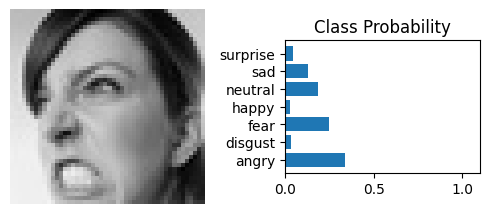

In [ ]:
image, label = validset[97]
image = image.unsqueeze(0)

logits = model(image.to(DEVICE))
probs = nn.Softmax(dim = 1)(logits)

view_classify(image.squeeze(), probs)

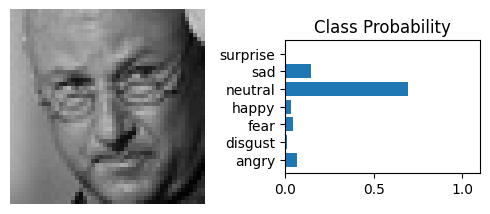

In [ ]:
image, label = validset[105]
image = image.unsqueeze(0)

logits = model(image.to(DEVICE))
probs = nn.Softmax(dim = 1)(logits)

view_classify(image.squeeze(), probs)